# **Google Play Store Apps** - Data Analysis

This notebook includes the procedure of making a descriptive analysis of google play store apps data obtained from [Kaggle](https://www.kaggle.com/datasets/lava18/google-play-store-apps) and cleaned previously.

## 1) Import Libraries

In [26]:
# import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import missingno as msno
from IPython.display import display_html
from packaging.version import parse, Version, LegacyVersion
from packaging.utils import canonicalize_version
from matplotlib.cbook import boxplot_stats
import os, re, warnings
import calendar

In [2]:
# inline is set automatically, so no need to call %matplotlib inline
matplotlib.get_backend()

'module://matplotlib_inline.backend_inline'

Why `%matplotlib inline` is unnecessary: https://stackoverflow.com/questions/65934740/is-matplotlib-inline-still-needed 

## 2) Load Dataframes

In [3]:
# load stored dataframes
%store -r

In [4]:
# app feature dataframe
df_feature.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9643 entries, 0 to 10840
Columns: 17 entries, app to android_ver
dtypes: datetime64[ns](1), float64(2), int64(5), object(9)
memory usage: 1.3+ MB


In [5]:
# app sentiment dataframe
df_review.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29692 entries, 0 to 64230
Columns: 5 entries, app to sentiment_subjectivity
dtypes: float64(2), object(3)
memory usage: 1.4+ MB


In [6]:
# outer merged dataframe
result_outer.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28250 entries, 0 to 28249
Columns: 21 entries, app to sentiment_subjectivity
dtypes: datetime64[ns](1), float64(4), int64(5), object(11)
memory usage: 4.7+ MB


In [7]:
# average merged dataframe
result_avg.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 816 entries, 0 to 815
Columns: 21 entries, app to sentiment_subjectivity
dtypes: datetime64[ns](1), float64(4), int64(6), object(10)
memory usage: 140.2+ KB


### 2.1) Remove Outliers

In this section we have reviewed our restored data and after a statistical analysis, we have removed the outliers for clearer analysis and plotting.

In [8]:
df_feature.describe()

,rating,reviews,installs,price,update_year,update_month,update_day
count,9643.000000,9.643000e+03,9.643000e+03,9643.000000,9643.000000,9643.000000,9643.000000
mean,4.174728,2.169492e+05,7.790242e+06,1.100763,2017.347091,6.366276,15.630094
std,0.496139,1.832817e+06,5.380195e+07,16.866079,1.135741,2.658896,9.430746
min,1.000000,0.000000e+00,0.000000e+00,0.000000,2010.000000,1.000000,1.000000
25%,4.000000,2.500000e+01,1.000000e+03,0.000000,2017.000000,5.000000,7.000000
50%,4.211712,9.700000e+02,1.000000e+05,0.000000,2018.000000,7.000000,16.000000
75%,4.500000,2.947350e+04,1.000000e+06,0.000000,2018.000000,8.000000,24.000000
max,5.000000,7.815831e+07,1.000000e+09,400.000000,2018.000000,12.000000,31.000000


In [9]:
result_avg.describe()

,rating,reviews,installs,price,update_year,update_month,update_day,review_count,sentiment_polarity,sentiment_subjectivity
count,816.000000,8.160000e+02,8.160000e+02,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000,816.000000
mean,4.282598,7.113919e+05,2.670946e+07,0.099767,2017.688725,6.729167,15.738971,34.620098,0.198687,0.490588
std,0.313643,3.640515e+06,1.099350e+08,1.278179,0.842823,1.927886,10.043794,20.097744,0.159898,0.084672
min,2.600000,1.140000e+02,1.000000e+03,0.000000,2011.000000,1.000000,1.000000,1.000000,-0.500000,0.000000
25%,4.100000,7.777750e+03,1.000000e+06,0.000000,2018.000000,6.000000,6.000000,27.000000,0.082347,0.451121
50%,4.300000,4.065050e+04,3.000000e+06,0.000000,2018.000000,7.000000,16.000000,36.000000,0.196592,0.496901
75%,4.500000,1.983450e+05,1.000000e+07,0.000000,2018.000000,8.000000,25.000000,39.000000,0.297215,0.536927
max,4.900000,7.815831e+07,1.000000e+09,29.990000,2018.000000,12.000000,31.000000,130.000000,1.000000,0.916667


For both dataframes, the most obvious problem with outliers arises in `price` feature as the std is even larger than the mean. We apply a percentile cut to this feature to remove the outliers in the dataset.

#### 2.1.1. df_feature_no (no outlier, only app features with no sentiment)
The distribution of `price` feature is not suitable to use inter quartile ratio with 25th and 75th percentiles. Thus, we decided to use the 3 standard deviation since 99.7% of data occurs within three standard deviations of the mean within a normal distribution.

In [10]:
# dropping the outlier rows with standard deviation using factor 3
factor = 3
upper_lim = df_feature.price.mean() + df_feature.price.std() * factor
lower_lim = df_feature.price.mean() - df_feature.price.std() * factor
# upper_lim = df_feature.price.quantile(.95)
# lower_lim = df_feature.price.quantile(.05)

# dataframe with no outliers
df_feature_no = df_feature[(df_feature.price > lower_lim) & (df_feature.price < upper_lim)]

print('Outlier removal (df_feature):')
print('µ-3σ:', lower_lim, '\nµ+3σ:', upper_lim)
print('Shape with Outliers:', df_feature.shape)
print('Shape without Outliers:', df_feature_no.shape)

Outlier removal (df_feature):
µ-3σ: -49.49747522324184 
µ+3σ: 51.69900171914558
Shape with Outliers: (9643, 17)
Shape without Outliers: (9620, 17)


#### 2.1.12 result_avg_no (no outlier, merged with averages)
Similar to the feature dataframe, we have used the 3 standard deviation to remove outliers.

In [11]:
# dropping the outlier rows with standard deviation using factor 3
factor = 3
upper_lim = result_avg.price.mean() + result_avg.price.std() * factor
lower_lim = result_avg.price.mean() - result_avg.price.std() * factor
# upper_lim = result_avg.price.quantile(.95)
# lower_lim = result_avg.price.quantile(.05)

# dataframe with no outliers
result_avg_no = result_avg[(result_avg.price > lower_lim) & (result_avg.price < upper_lim)]

print('Outlier removal (result_avg):')
print('µ-3σ:', lower_lim, '\nµ+3σ:', upper_lim)
print('Shape with Outliers:', result_avg.shape)
print('Shape without Outliers:', result_avg_no.shape)

Outlier removal (result_avg):
µ-3σ: -3.734769105296471 
µ+3σ: 3.934303419021961
Shape with Outliers: (816, 21)
Shape without Outliers: (809, 21)


## 3) General Analysis

In this section we have reviewed the overall distribution of features and some feature relationships.
### 3.1) Who are the winner? (Using df_feature and df_review) (Beste)
In this section we only aimed to present the top 5 of selected fetures without excluding statistical outliers.

In [12]:
# function to print the desired columns with number formatting
def print_top(df, col_str, col_num, item_num):
    for i in range(item_num):
        print(df.iloc[i][col_str], ":","{:,}".format(df.iloc[i][col_num]))

In [13]:
# top most downloaded apps:
most_downloaded = df_feature.sort_values(['installs'], ascending=False).head(5)
print_top(most_downloaded,'app','installs',len(most_downloaded))

Google News : 1,000,000,000
Gmail : 1,000,000,000
Google Play Games : 1,000,000,000
YouTube : 1,000,000,000
Google Play Movies & TV : 1,000,000,000


In [14]:
# top most reviewed apps:
highest_review = df_feature.sort_values(['reviews'],ascending=False).head(5)
print_top(highest_review,'app','reviews',len(highest_review))

Facebook : 78,158,306
WhatsApp Messenger : 69,119,316
Instagram : 66,577,313
Messenger – Text and Video Chat for Free : 56,642,847
Clash of Clans : 44,891,723


In [15]:
# top most rated apps:
highest_rated = df_feature.sort_values(['rating'],ascending=False).head(5)
print_top(highest_rated,'app','rating',len(highest_rated))

Brick Breaker BR : 5.0
AJ Men's Grooming : 5.0
Wowkwis aq Ka'qaquj : 5.0
DF Glue Board : 5.0
Clinic Doctor EHr : 5.0


__TODO (Sunmbal):__ Add below top 5 selection using df_feature dataframe. Hint: use value_counts to count comment and positives

In [ ]:
# top most commented apps:

In [ ]:
# top most positive comment apps:

In [16]:
warnings.simplefilter(action='ignore', category=FutureWarning)

### 3.2) General Numeric: The distribution of numerics and their relationships (using result_avg_no) (Beste)

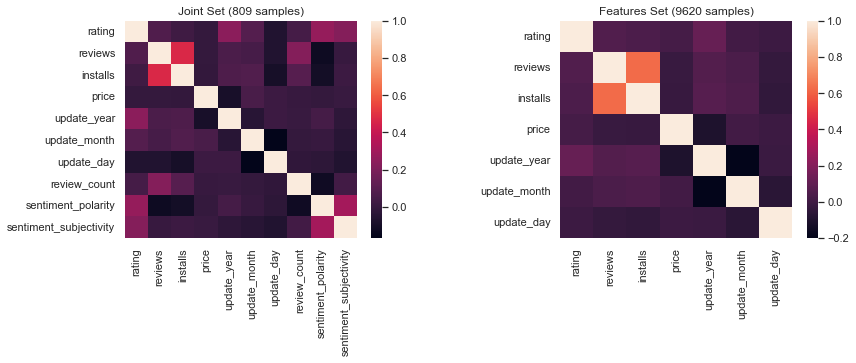

In [17]:
# set seaborn properties
sns.set_theme(style="dark")
sns.set_context('notebook')
sns.set_palette('colorblind')

# plot pairwise correlations
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(13,4))

sns.heatmap(result_avg_no.corr(), ax=ax0)
ax0.set(title="Joint Set (%i samples)" %len(result_avg_no))

sns.heatmap(df_feature_no.corr(), ax=ax1)
ax1.set(title="Features Set (%i samples)" %len(df_feature_no))

plt.subplots_adjust(wspace=.5)

As we see from the heatmap above; 
- Higher correlation pairs: `reviews-installs`
- Medium correlation pairs: `rating-sentiment_polarity`, `sentiment_polarity-sentiment_subjectivity`
- Lower correlation pairs: `rating-update_year`, `rating-sentiment_subjectivity`
The remaining correlations can be eliminated from performing further analysis pairwise with numeric features.

#### 3.2.1. Reviews VS Installs

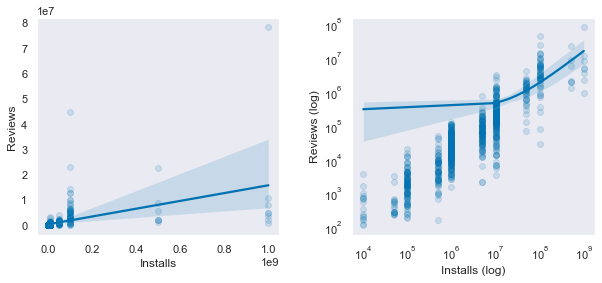

In [18]:
# call regplot on each axes
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(10,4))

# left plot with normal scale
sns.regplot(data=result_avg_no, y='reviews', x='installs', scatter_kws={'alpha':0.15}, ax=ax0)
ax0.set(xlabel="Installs", ylabel="Reviews")

# right plot with log scale to observe the spread more evenly
sns.regplot(data=result_avg_no, y='reviews', x='installs', truncate=True, scatter_kws={'alpha':0.15}, ax=ax1)
ax1.set(xlabel="Installs (log)", ylabel="Reviews (log)", xscale="log", yscale="log")

plt.subplots_adjust(wspace=.3)

 - __*Result:*__ We have only confirmed that there is a positive correlation between the installation amount and review amount which was only a known fact.  

#### 3.2.2. Rating VS Correlated Columns

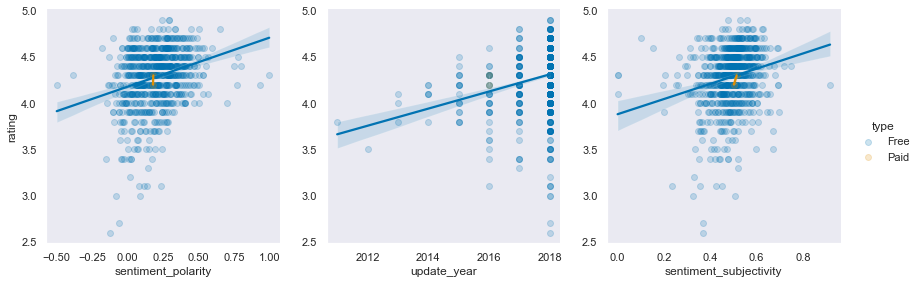

In [19]:
# rating vs sentiment_polarity, update_year and sentiment_subjectivity
x_vars = ['sentiment_polarity', 'update_year', 'sentiment_subjectivity']
y_vars = ['rating']
g = sns.pairplot(data=result_avg_no, x_vars=x_vars, y_vars=y_vars,
                 hue='type', height=4, kind='reg', plot_kws={'scatter_kws': {'alpha': 0.2}})

# iterate over all subplots to add yticks on each individually
for ax in g.axes.flat:
    ax.tick_params(axis='y', labelleft=True) # method 1
    # ax.yaxis.set_tick_params(labelleft=True) # method 2

plt.subplots_adjust(wspace=.2)

- __*Result:*__ We have only confirmed that there is a slight positive correlation between the rating and sentiment subfields which was only a known fact (we expected an app to be rated higher if the reviews were positive and vice versa). It was rather slightly surprising to confirm the positive corelation between the rating and the update year which made us deduct the fact that:
> __*Keeping an app updated would likely increase the rating.*__



### 3.3) General Categorical: The distribution of categories and their relationships (using result_avg_no) (Beste)
 
#### 3.3.1. General Distribution of apps per categorical features (by # and %)

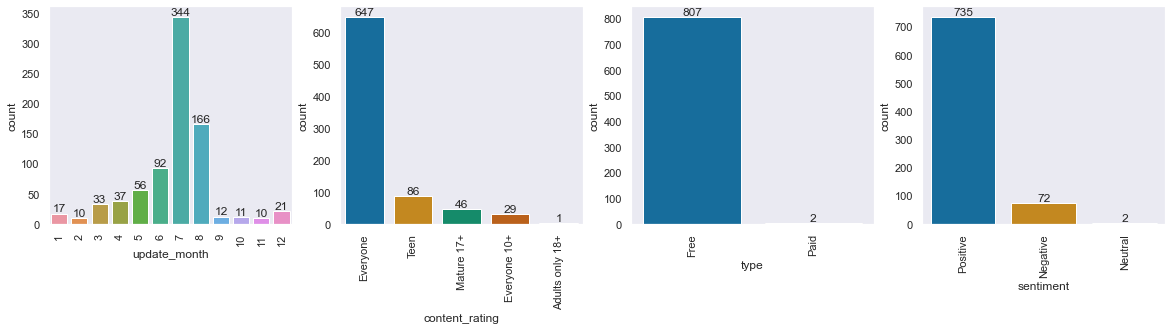

In [20]:
# count plots of selected categorical columns
categorical = ['update_month', 'content_rating', 'type', 'sentiment']

fig, ax = plt.subplots(1, 4, figsize=(20, 4))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(result_avg_no[variable], ax=subplot)
    subplot.bar_label(subplot.containers[0])
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

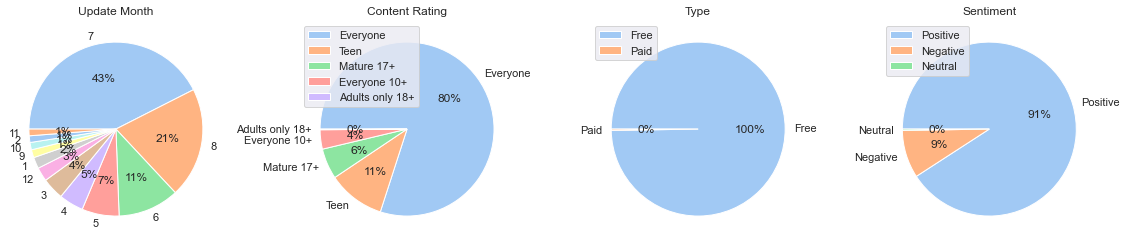

In [21]:
# pie charts of selected categorical columns
categorical = ['update_month', 'content_rating', 'type', 'sentiment']

# define Seaborn color palette to use
colors = sns.color_palette('pastel')

fig, ax = plt.subplots(1, 4, figsize=(20, 4))
for variable, subplot in zip(categorical, ax.flatten()):
    data_plot = result_avg_no[variable].value_counts()
    subplot.pie(data_plot.values, labels=data_plot.index, startangle=180, counterclock=False, colors=colors, autopct='%.0f%%')
    subplot.set(title=variable.replace('_',' ').title())
    if(variable != 'update_month'):
        subplot.legend(loc='upper left')

#### 3.3.2. Distribution of apps per category and genre (by # and %)

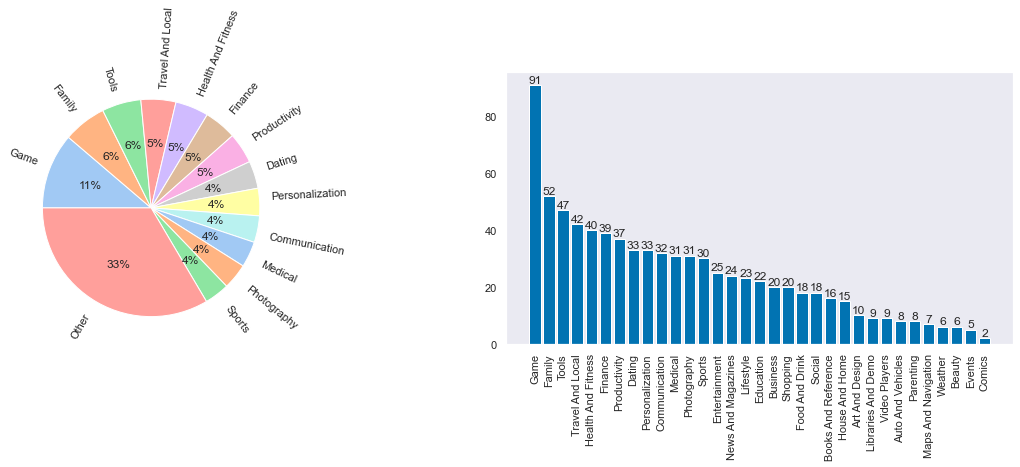

In [22]:
# distribution per app category (combine categories repeating less than 30 as `Other`)
categories = result_avg_no.category.value_counts()
combined = categories[categories.values<30].sum()
separate = categories[categories.values>=30]

# short list specific to pie chart
data_category_pie = np.append(separate.values, combined)
labels_pie = [item.replace('_', ' ') for item in separate.index.map(str.title)] + ['Other']

# fulllist for bar plot
labels = [item.replace('_', ' ') for item in categories.index.map(str.title)]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 5))
ax0.pie(data_category_pie, labels=labels_pie, rotatelabels=True, startangle=180, counterclock=False, colors=colors, autopct='%.0f%%')
bars = ax1.bar(labels, categories)
ax1.bar_label(bars)
for label in ax1.get_xticklabels():
    label.set_rotation(90)

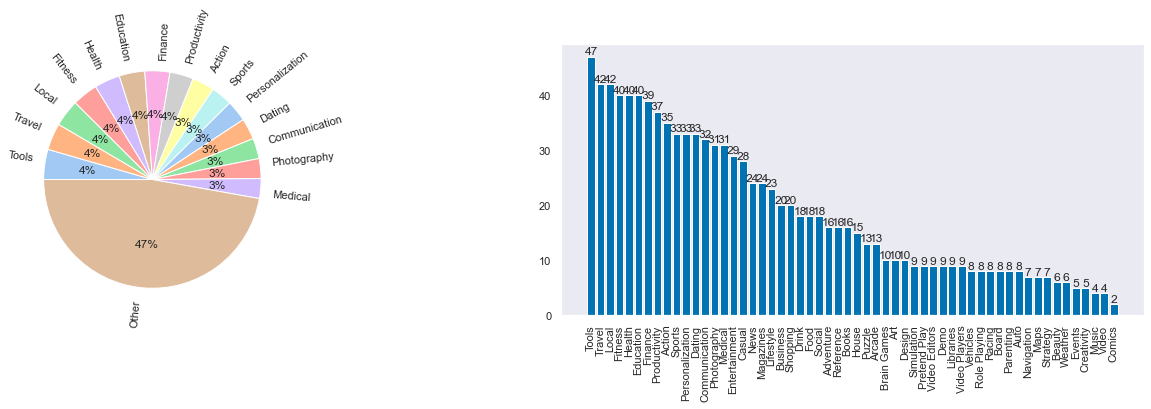

In [23]:
# distribution per app genres
genres = result_avg_no.genres.explode().value_counts()
combined = genres[genres.values<30].sum()
separate = genres[genres.values>=30]

# short list specific to pie chart
data_genre_pie = np.append(separate.values, combined)
labels_pie = [item.replace('_', ' ') for item in separate.index.map(str.title)] + ['Other']

# fulllist for bar plot
labels = [item.replace('_', ' ') for item in genres.index.map(str.title)]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(23, 5))
ax0.pie(data_genre_pie, labels=labels_pie, rotatelabels=True, startangle=180, counterclock=False, colors=colors, autopct='%.0f%%')
bars = ax1.bar(labels, genres, align='center')
ax1.bar_label(bars)
for label in ax1.get_xticklabels():
    label.set_rotation(90)

__TODO (Sunmbal):__ Add a pie chart of the most used combinations of genres.

In [ ]:
# pie chart of the most used combinations of genres

## 4) Analysis Questions

In this section we have asked some questions to understand our data better and replied those questions with data analysis and plotting.

### 4.1) Does the update date (day, month) affect the number of installs? (using df_feature_no) (Beste)

__Question:__ Can we conclude that the apps are likely to be updated on July the most because the users tent to check and install more apps during July (or summer)? Or is it only a developer behavior with no visible affect on installs?

On which months are users more likely to download apps? And which categories? (eg. diet before summer) What could be the reason?

In [24]:
# observe the distribution of installs per update month
df_feature_no.groupby(['update_month'])['installs'].describe()

,count,mean,std,min,25%,50%,75%,max
update_month,,,,,,,,
1,466.0,2.212846e+06,9.933621e+06,0.0,1000.0,10000.0,500000.0,1.000000e+08
2,514.0,1.494750e+06,8.644377e+06,1.0,625.0,10000.0,100000.0,1.000000e+08
3,637.0,1.403521e+06,7.341779e+06,0.0,1000.0,10000.0,100000.0,1.000000e+08
4,573.0,2.540078e+06,1.110135e+07,0.0,500.0,10000.0,500000.0,1.000000e+08
5,922.0,3.954857e+06,2.556825e+07,1.0,1000.0,50000.0,1000000.0,5.000000e+08
6,1162.0,4.177561e+06,1.957023e+07,1.0,1000.0,100000.0,1000000.0,5.000000e+08
7,2605.0,1.099623e+07,6.027721e+07,0.0,10000.0,500000.0,5000000.0,1.000000e+09
8,1284.0,2.416749e+07,1.136167e+08,0.0,10000.0,1000000.0,10000000.0,1.000000e+09
9,305.0,1.360532e+06,7.248171e+06,5.0,1000.0,10000.0,100000.0,1.000000e+08


In [27]:
# observe the count of outliers per month
for month, data in df_feature_no.groupby('update_month'):
    data = data["installs"]
    print(f'{calendar.month_name[month]} Outliers', end=" ")
    stats = boxplot_stats(data)
    for stat in stats:
        outliers = pd.Series(stat['fliers'].tolist()).value_counts().to_dict()        
        print("(",sum(outliers.values()),")",{"{:.0e}".format(k):v for k,v in outliers.items()})

January Outliers ( 52 ) {'1e+07': 27, '5e+06': 16, '5e+07': 6, '1e+08': 3}
February Outliers ( 121 ) {'1e+06': 49, '5e+05': 31, '5e+06': 21, '1e+07': 14, '1e+08': 3, '5e+07': 3}
March Outliers ( 154 ) {'1e+06': 79, '5e+05': 25, '1e+07': 25, '5e+06': 18, '5e+07': 5, '1e+08': 2}
April Outliers ( 73 ) {'1e+07': 35, '5e+06': 25, '5e+07': 8, '1e+08': 5}
May Outliers ( 157 ) {'1e+07': 74, '5e+06': 59, '5e+07': 15, '1e+08': 7, '5e+08': 2}
June Outliers ( 233 ) {'1e+07': 131, '5e+06': 66, '5e+07': 20, '1e+08': 15, '5e+08': 1}
July Outliers ( 177 ) {'5e+07': 82, '1e+08': 78, '5e+08': 11, '1e+09': 6}
August Outliers ( 138 ) {'1e+08': 67, '5e+07': 47, '1e+09': 14, '5e+08': 10}
September Outliers ( 71 ) {'1e+06': 31, '5e+05': 16, '1e+07': 13, '5e+06': 8, '5e+07': 2, '1e+08': 1}
October Outliers ( 86 ) {'1e+06': 33, '5e+05': 17, '1e+07': 17, '5e+06': 16, '5e+07': 3}
November Outliers ( 42 ) {'5e+06': 17, '1e+07': 16, '5e+07': 6, '1e+08': 3}
December Outliers ( 49 ) {'1e+07': 23, '5e+06': 17, '5e+07

In [58]:
type_filtered = df_feature_no[['update_month','type']].copy()
type_filtered.loc[:,'update_month'] = [calendar.month_name[i] for i in type_filtered.update_month.values]
type_filtered

,update_month,type
0,January,Free
1,January,Free
2,August,Free
3,June,Free
4,June,Free
...,...,...
10834,June,Free
10836,July,Free
10837,July,Free
10839,January,Free


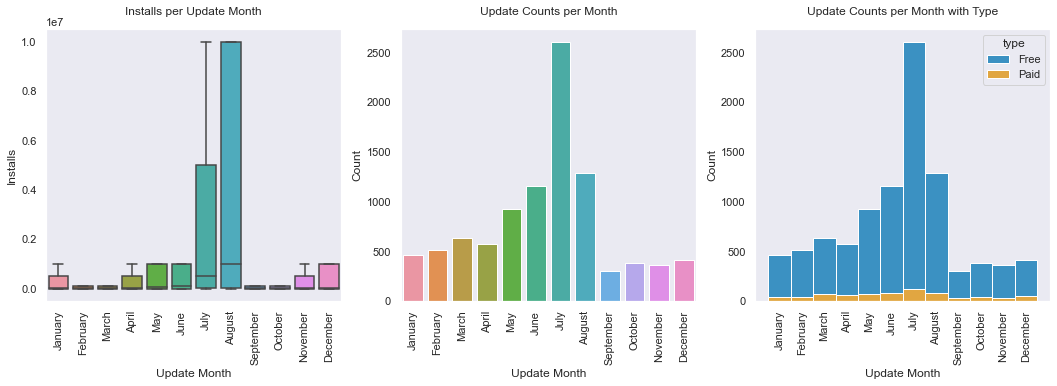

In [71]:
# count plots of selected categorical columns
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(18,5))

# left plot for boxplot of installations
sns.boxplot(x=[calendar.month_name[i] for i in df_feature_no.update_month.values.tolist()], y="installs", 
            data=df_feature_no, sym="", order=calendar.month_name[1:], ax=ax0)
ax0.set_title("Installs per Update Month", y=1.03)
ax0.set(xlabel="Update Month", ylabel="Installs")
ax0.set_xticklabels(calendar.month_name[1:], rotation=90)

# center plot for update counts
sns.countplot(pd.Series([calendar.month_name[i] for i in df_feature_no.update_month.values]), 
              order=calendar.month_name[1:], ax=ax1)
ax1.set_title("Update Counts per Month", y=1.03)
ax1.set(xlabel="Update Month", ylabel="Count")
ax1.set_xticklabels(calendar.month_name[1:], rotation=90)

# right plot for update counts with type
type_filtered = df_feature_no[['update_month','type']].copy()
type_filtered.loc[:,'update_month'] = [calendar.month_name[i] for i in type_filtered.update_month.values]
type_filtered.update_month = pd.Categorical(type_filtered.update_month, calendar.month_name[1:])

sns.histplot(binwidth=0.5, x="update_month", hue="type", data=type_filtered, 
             stat="count", multiple="stack", ax=ax2)
ax2.set_title("Update Counts per Month with Type", y=1.03)
ax2.set(xlabel="Update Month", ylabel="Count")
ax2.set_xticks(range(12))
ax2.set_xticklabels(calendar.month_name[1:], rotation=90)

plt.subplots_adjust(wspace=.2)

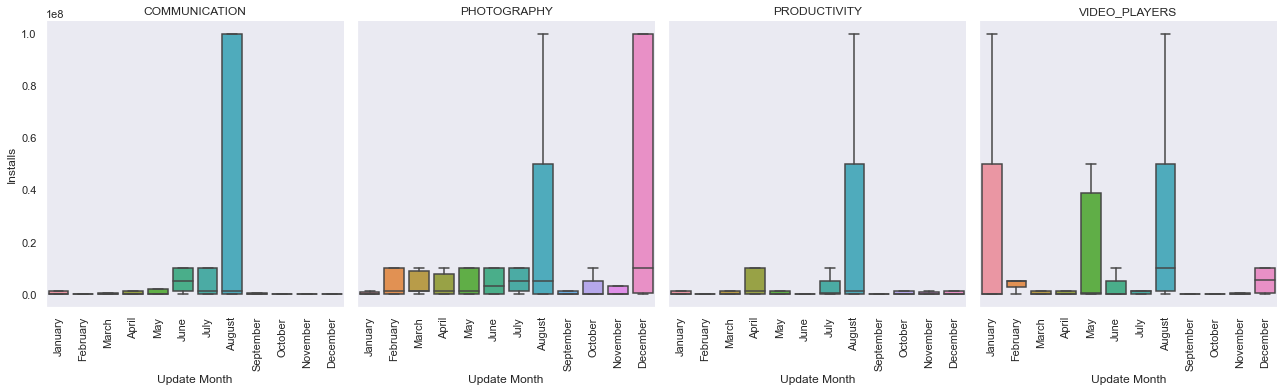

In [30]:
# filter out the categories with high and diverse installation per month
filtered_categories = df_feature_no.groupby(["category","update_month"])["installs"].mean().groupby(
    ["category"]).mean().sort_values(ascending=False).index.tolist()[:4]
filtered_data = df_feature_no[df_feature_no.category.isin(filtered_categories)]

# plot by categories
g =sns.catplot(x="update_month", y="installs", data=filtered_data, sym="", 
               kind="box", col="category", aspect=0.9)
g.set_axis_labels("Update Month", "Installs").set_xticklabels(
    calendar.month_name[1:], rotation=90).set_titles('{col_name}');

- __*Result:*__ We observe that the number of installs are higher if the app is updated in the summer months, especially on July and August. Considering the large number of applications being updated on summer months, a higher number of installation is within the expectations. Even though, considering the very small positive correlation between the two, we may deduct the fact that:
> __*An app released (first update) or updated during the summer will likely to get higher number of installations.*__
  
  We also review the number of installations per month per category to observe any possible relation of the app categories and summer months and obtain the most obvious distribution results for above 4 categories. While it is slightly harder to make a comment on `PRODUCTIVITY` due to the diverse range of features of apps in this category, we deduct below statements for remaining features `COMMUNICATION`, `PHOTOGRAPHY` and `VIDEO_PLAYERS`: 
> __*Communication apps released or updated during the summer will likely to get higher number of installations (due to higher demand on socializing during holidays).*__

 > __*Photography apps released or updated during the summer will likely to get higher number of installations (due to higher demand to take pictures on summer holiday-similar case for winter).*__

 > __*Video player apps released or updated during the summer will likely to get higher number of installations (due to longer free time to watch contents).*__

__TODO (Sunmbal):__ Review above 4 categories by also dividing by `type` (Free,Paid) and comment on results. 

In [ ]:
# plot per category column and type row

### 4.2) How does the number of app per category affect? (using ...) (Gaia)

__Question:__ Which category is associated to the most/least number of apps? In the latter case, how are installs and reviews? Does less associated apps = worse quality? Why?

We know from the graphs at section 3.1 that 'game','family' and 'beauty' are the top 3 categories for associated apps. In contrast, 'comics', 'events' and 'weather' are the bottom 3. 

In [ ]:
# display bottom 3 categories in terms of associated apps and check

### 4.3) Price analysis (using ...) (Gaia)

__Question:__ What is the average price for paid apps? 

Use both mean() and median(). There is one or more big outlier(s). Let's see how they affect our statistics and decide whether we want to get rid of it/them or not. (For this specific task, let's use whisker/violin/scatter plots to highlight the outliers (maybe with scatter?) and the std before and after removing them (violin?)).

In [ ]:
#try to use the df_feature dataset and get rid of outliers (use std/percentiles) and plot the whole thing again
#creating a sub-dataframe with paid apps only 
paid_apps=df_feature[df_feature.type=='Paid']
paid_apps.head()

In [ ]:
#display mean and median of the new dataframe
paid_apps.price.agg(['min','max','mean','median','std'])

In [ ]:
sns.set_theme(style='white')
sns.boxplot(data=paid_apps, x="price")

The difference between mean and median, the huge standard deviation and the boxplot show us that there are a few outliers which drastically affect our price column. For this reason, we decided to get rid of those outliers. If we use the result_avg dataframe instead, we can see that the values are definitely more homogenous.

In [ ]:
#using the result_avg dataframe
result_avg.price.agg(['min','max','mean','median','std'])

In [ ]:
paid_apps=result_avg[result_avg.type=='Paid']
sns.set_theme(style='white')
sns.boxplot(data=paid_apps, x="price")

### 4.4) Why some apps are lagging behind? (using ...) (Gaia)

__Question:__ Which apps were not updated in year 2018? What was the overall sentiment/polarity for those apps? Could it mean they were abandoned? Or that they are going to be improved in the future?

In [ ]:
#creating a new sub-dataframe with apps which were not updated in year 2018
not_updated=result_avg[result_avg.update_year!=2018.0]
not_updated.head()

In [ ]:
#what is the sentiment over these not updated apps?
not_updated.sentiment.value_counts() / len(not_updated)

In [ ]:
#what is the sentiment polarity?
not_updated.sentiment_polarity.agg(['mean','median'])

### 4.5) Does free=positive reviews and paid=negative reviews? (using result_avg) (Beste)

__Question:__ Is there an overall correlation between free and positive sentiment or paid and negative sentiment?
For this specific analysis, we are not using the dataframe wehre the outliers are removed due to majority of paid apps being outliers.

In [31]:
# filter paid apps
paid_apps=result_avg[result_avg.type=='Paid']

# observe sentiment distribution of paid app reviews
paid_apps.groupby("sentiment")["review_count"].sum() / paid_apps.review_count.sum() 

sentiment
Negative    0.009901
Positive    0.990099
Name: review_count, dtype: float64

In [32]:
# filter free apps
free_apps=result_avg[result_avg.type=='Free']

# observe sentiment distribution of paid app reviews
free_apps.groupby("sentiment")["review_count"].sum() / free_apps.review_count.sum() 

sentiment
Negative    0.083265
Neutral     0.000072
Positive    0.916664
Name: review_count, dtype: float64

In [33]:
# observe type distribution of negative app reviews
result_avg[result_avg.sentiment=='Negative'].groupby("type")["review_count"].sum()

type
Free    2327
Paid       3
Name: review_count, dtype: int64

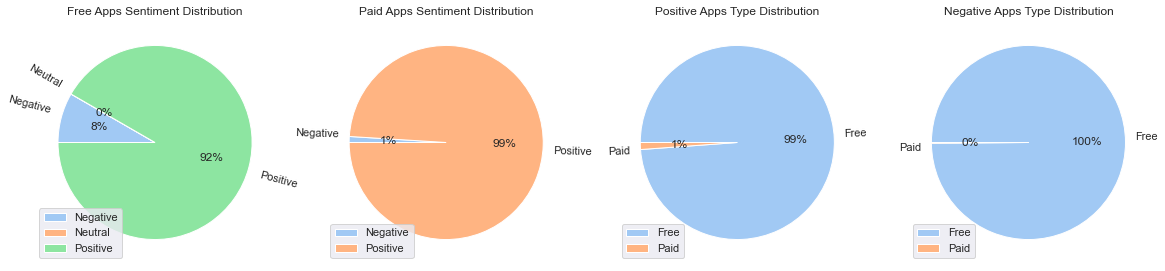

In [34]:
# pie charts of app review sentiments by type
free_dist = free_apps.groupby("sentiment")["review_count"].sum() / free_apps.review_count.sum() 
paid_dist = paid_apps.groupby("sentiment")["review_count"].sum() / paid_apps.review_count.sum()
positives = result_avg[result_avg.sentiment=='Positive'].groupby("type")["review_count"].sum()
negatives = result_avg[result_avg.sentiment=='Negative'].groupby("type")["review_count"].sum()

fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20, 5))
ax0.pie(free_dist.values, labels=free_dist.index, rotatelabels=True, startangle=180, counterclock=False, colors=colors, autopct='%.0f%%')
ax0.set(title="Free Apps Sentiment Distribution")
ax0.legend(loc='lower left');
ax1.pie(paid_dist.values, labels=paid_dist.index, rotatelabels=True, startangle=180, counterclock=False, colors=colors, autopct='%.0f%%')
ax1.set(title="Paid Apps Sentiment Distribution")
ax1.legend(loc='lower left');
ax2.pie(positives.values, labels=positives.index, rotatelabels=True, startangle=180, counterclock=False, colors=colors, autopct='%.0f%%')
ax2.set(title="Positive Apps Type Distribution")
ax2.legend(loc='lower left');
ax3.pie(negatives.values, labels=negatives.index, rotatelabels=True, startangle=180, counterclock=False, colors=colors, autopct='%.0f%%')
ax3.set(title="Negative Apps Type Distribution")
ax3.legend(loc='lower left');

- __*Result:*__ We observe that there is no direct relationship between the app type and reviews' sentiment. While we observe that majority of paid apps are reviewed with positive comments and there are more negatively reviewed free apps, the difference in amount of free and paid apps makes a distinctive analysis impossible. However, in contrary to our expectations of app users being tended to leave negative comments, we saw that the majority of reviews were positive and the users left comments more to appreciate the apps.

__TODO (Sunmbal):__ Observe the percentage of users leaving comments by type by sentiment. To do so, compare `reviews`(total users rating the app) with `review_count`(total users leaving a text review) to check the validity of sentiment assessment.

In [ ]:
# validity of sentiment assessment

### 4.6) Who are the happiest users? (using result_avg_no) (Beste)

__Question:__ Is there a specific content ranking category that seems to be expressing more negative sentiment towards apps in general? If so, which one(s)? 

In [49]:
# reviews (total rating votes) and review counts (total text reviews)
df_cr = result_avg_no.groupby(['content_rating'])['reviews','review_count'].sum()

# min, max and mean rating, rating count and total installs
df_cr.insert(loc=0, column='installs',
             value=result_avg.groupby(['content_rating'])['installs'].sum().values.reshape([5]))
df_cr.insert(loc=(df_cr.columns.get_loc('review_count')), column='app_count',
             value=result_avg.groupby(['content_rating'])['rating'].count().values.reshape([5]))
df_cr.insert(loc=(df_cr.columns.get_loc('review_count')), column='min_rating',
             value=result_avg.groupby(['content_rating'])['rating'].min().values.reshape([5]))
df_cr.insert(loc=(df_cr.columns.get_loc('review_count')), column='mean_rating',
             value=result_avg.groupby(['content_rating'])['rating'].mean().values.reshape([5]))
df_cr.insert(loc=(df_cr.columns.get_loc('review_count')), column='max_rating',
             value=result_avg.groupby(['content_rating'])['rating'].max().values.reshape([5]))

# mean sentiment_polarity and sentiment
df_cr.insert(loc=len(df_cr.columns), column='mean_polarity',
             value=result_avg.groupby(['content_rating'])['sentiment_polarity'].mean().values.reshape([5]))
df_cr.insert(loc=len(df_cr.columns), column='sentiment',
             value=(np.where(df_cr.mean_polarity > 0,"Positive",
                             np.where(df_cr.mean_polarity < 0, "Negative", "Neutral"))))

df_cr.sort_values('reviews',ascending=False)

,installs,reviews,app_count,min_rating,mean_rating,max_rating,review_count,mean_polarity,sentiment
content_rating,,,,,,,,,
Everyone,15423781000,334336401,652,2.6,4.282515,4.9,22103,0.206188,Positive
Teen,5256770000,164469558,87,3.7,4.314943,4.9,3222,0.163186,Positive
Everyone 10+,810300000,72559222,29,4.0,4.389655,4.8,1076,0.140337,Positive
Mature 17+,303070000,9039896,47,3.3,4.153191,4.7,1579,0.194216,Positive
Adults only 18+,1000000,50017,1,4.5,4.500000,4.5,35,0.298400,Positive


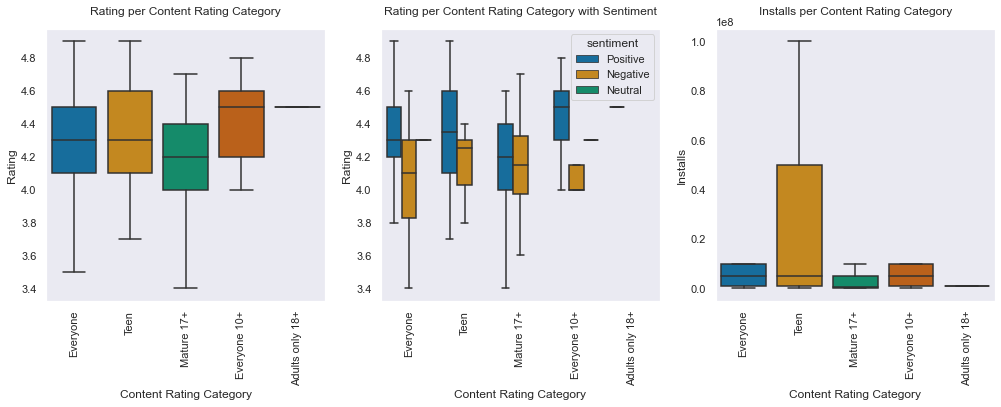

In [45]:
# count plots of selected categorical columns
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(17,5))

# left plot for boxplot of content rating
sns.boxplot(x="content_rating", y="rating", 
            data=result_avg_no, sym="", ax=ax0)
ax0.set_title("Rating per Content Rating Category", y=1.03)
ax0.set(xlabel="Content Rating Category", ylabel="Rating")
ax0.set_xticklabels(result_avg_no.content_rating.value_counts().index, rotation=90)

# center plot for sentiment
sns.boxplot(x="content_rating", y="rating", hue="sentiment",
            data=result_avg_no, sym="", ax=ax1)
ax1.set_title("Rating per Content Rating Category with Sentiment", y=1.03)
ax1.set(xlabel="Content Rating Category", ylabel="Rating")
ax1.set_xticklabels(result_avg_no.content_rating.value_counts().index, rotation=90)

# right plot for installs
sns.boxplot(x="content_rating", y="installs",
            data=result_avg_no, sym="", ax=ax2)
ax2.set_title("Installs per Content Rating Category", y=1.03)
ax2.set(xlabel="Content Rating Category", ylabel="Installs")
ax2.set_xticklabels(result_avg_no.content_rating.value_counts().index, rotation=90)

plt.subplots_adjust(wspace=.2)

- __*Result:*__ We observe that the content rating category `Everyone` has the most applications, and thusalso has the most diverge ratings. When we consider the mean value and spread of whiskers, we see that the category `Everyone 10+`is generally rated higher and has more positive reviews while we see a skew to negative side for the category `Mature 17+`. Due to the number of applications, it is not possible to compare the category `Adults only 18+` even though very few applications are rated positively. From these observations, we may deduct that:

 > __*The apps in the `Everyone 10+` content rating category are likely to be rated higher than other categories.*__
  
 On the other hand, we see that mean installation numbers are close for categories `Everyone`, `Teen` and `Everyone 10+` while `Teen` category has the most diverge range. From these observations, we may deduct that:

 > __*The apps in the `Teen` content rating category are likely to be installed more.*__

### 4.7) Does the size of the app affect the installs? (using ...) (Gaia and Beste)

__Question:__ Which apps categories (top 5?) have a larger mean size? Are those categories similar or are they totally differnt? Are there outliers or is the distribution homogenous? (great chance o use scatter plots here!) Is there any correlation between the size of the app and the installs? Do people overall prefer installing smaller apps?

In [ ]:
#apps with varying sizes!!!
#display the 5 categories with the biggest mean apps size
#We can figure out if having a big sized app can be a disadvantage
biggest_apps=result_avg.sort_values(['category','size'],ascending=False).groupby('category').mean() #why sorting alphabetical??
biggest_apps.head()

In [ ]:
#display the 5 categories with the smallest mean apps size
smallest_apps=result_avg.sort_values(['category','size'],ascending=False).groupby('category').mean() #why sorting alphabetical??
smallest_apps.tail()

In [ ]:
## scatter plots for size distribution for various categories
#graph per category plot

### 4.8) Does the version of the app affect the installs or ratings? (using ...) (Sunmbal)
__Question:__ Does having and app being updated more often to higher app versions increase the number of installations or ratings?

### 4.9) Does the version of the app have any relation with app type? (using ...) (Sunmbal)
__Question:__ Do free apps require more updates?

### 4.10) CONCLUSIONS -  Answers to our preliminary questions:

- Does more downloaded apps have a better rating? <br>
  **No, we couldn't detect any valuable correlation between the two.**
- On which days are users more likely to download apps? On weekend? Or during weekdays? What could be the reason?<br> 
  **Even though we cannot confirm the day the app is downloaded by the user, we saw that the apps updated on Saturday had the highest number of installs.**
  
  ...

## 5) Advanced Analysis

In this section we have worked on a selected business problem and performed a detailed analysis to make a business decision.

**Business objective: creating a medical app. The app should ideally be for users 17+ and NOT free.**

Business analysis: 
- *SWOT analyses (before and after advanced analysis)* 
- *analysis of competitors*
- *analysis of target users*

(This is an extremely simplified business analysis model as you can guess, but we have limited data availability and we do not have a budgeting plan, nor any specific technical requirements for our app - which heavily affects the considerations we can do about business decisions. That being said, I think we have enough points to analyze, given the objective of the project).

IMPORTANT: the competitors' analysis will be heavily reduced, since we can only analyze the "competitive apps" and not the competitive companies. 

In [ ]:
# new dataset with ALL medical apps
df_medical = df_feature[df_feature.category=="MEDICAL"]
df_medical.head()

In [ ]:
len(df_medical)

In [ ]:
# sample to try other categories
result_avg.sort_values(['installs'], ascending=False).loc[(result_avg.category=="SOCIAL")].head()

df_medical = df_feature.loc[(df_feature.category=="SOCIAL") & (df_feature.type=="Paid")]
len(df_medical)

### 5.1) SWOT Analysis (before advanced analysis)
In this section we will quickly go through the Strenghts, Weaknesses, Opportunities and Threats, based on the information we have gathered through the general analysis of the dataset.

- Strenghts:    to be filled
- Weaknesses:    to be filled 
- Opportunities:   to be filled
- Threads:     to be filled

### 5.2) Competitors' Analysis
- Top rated PAID apps: which categories? Any medical/health app included?

- Top rated PAID medical/health apps: what is the ranking? And the sentiment? Are the users generally happy about those apps?
- Top rated NON PAID medical/health apps: what is the ranking? And the sentiment? Are the users generally happy about those apps? 
- COMPARE THE TWO PREVIOUS POINTS AND DRAW CONCLUSIONS

- Top rated PAID medical/health apps: when were they last updated? With this, we can understand whether these apps are recent or not. We can also check which are the, say, top 3 paid apps that have not been updated in 2017 and figure out if they still exist or not - and therefore if we should consider them as competition or not. 

In [ ]:
#create dataframe with paid apps from result_avg dataframe. Sort apps according to rating.
paid_apps_avg=df_feature[df_feature.type=='Paid']
rated_paid_medical= paid_apps_avg[paid_apps_avg.category=='MEDICAL'].sort_values('rating',ascending=False)
rated_paid_medical.head()

### 5.3) Target Users' Analysis
- What is the most common content rating for medical apps? Does it make any sense to restrict it to 17+ or should we review this decision? (also review the various type of content rating

- Is there a correlation between Paid/17+ apps? Or Free/Everyone app? What is the Paid/whichever category below 17 app? So, are 17+ people more willing to spend money for apps?

In [ ]:
#Checking most common content rating for medical apps. Perhaps restricting to 17+ is not the wisest choice.
df_medical.content_rating.value_counts() / len(df_medical) 

### 5.4) SWOT Analysis (after advanced analysis)
In this section we will list Strenghts, Weaknesses, Opportunities and Threats, based on the information we have gathered through the advanced analysis of the dataset. Afterwards, we can compare our new SWOT analysis to the older one and we can draw conclusions.

- Strenghts:    to be filled
- Weaknesses:    to be filled 
- Opportunities:   to be filled
- Threads:     to be filled

## 6) Conclusions